In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.gridspec import GridSpec
import data_clean_utility
from scipy.stats import chi2_contingency, f_oneway, jarque_bera, probplot 
import plotly.express as px 

In [2]:
df = pd.read_csv('swiggy.csv')

In [3]:
data_clean_utility.perform_data_cleaning(df)

In [4]:
df_final = pd.read_csv('swiggy_cleaned.csv')

In [5]:
df_final.head()

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,time_taken,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,24,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,33,BANG,25,3,friday,0,5.0,19.0,evening,20.183530
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,26,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,21,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,30,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138


In [6]:
df_final.shape

(45502, 26)

In [7]:
df_final.isnull().sum()

rider_id                   0
age                     1854
ratings                 1908
restaurant_latitude     3630
restaurant_longitude    3630
delivery_latitude       3630
delivery_longitude      3630
order_date                 0
weather                  525
traffic                  510
vehicle_condition          0
type_of_order              0
type_of_vehicle            0
multiple_deliveries      993
festival                 228
city_type               1198
time_taken                 0
city_name                  0
order_day                  0
order_month                0
order_day_of_week          0
is_weekend                 0
pickup_time_minutes     1640
order_time_hour         1640
order_time_of_day          0
distance                3630
dtype: int64

In [8]:
missing_rows = (
    df_final
    .isnull()
    .any(axis = 1)
    .sum()
)

print(f"There are {missing_rows} rows with missing values the data")

print(f"Percentage of missing rows : {(missing_rows/df_final.shape[0])*100: .2f}%")

There are 7438 rows with missing values the data
Percentage of missing rows :  16.35%


In [9]:
df_final.duplicated().sum()

np.int64(0)

In [10]:
df_final.dtypes

rider_id                 object
age                     float64
ratings                 float64
restaurant_latitude     float64
restaurant_longitude    float64
delivery_latitude       float64
delivery_longitude      float64
order_date               object
weather                  object
traffic                  object
vehicle_condition         int64
type_of_order            object
type_of_vehicle          object
multiple_deliveries     float64
festival                 object
city_type                object
time_taken                int64
city_name                object
order_day                 int64
order_month               int64
order_day_of_week        object
is_weekend                int64
pickup_time_minutes     float64
order_time_hour         float64
order_time_of_day        object
distance                float64
dtype: object

In [11]:
nums_cols = df_final.columns[[1, 2, 3, 4, 5, 6, 16 , 22, 25]].tolist()

cat_cols = [col for col in df_final.columns if col not in nums_cols]


print(f"No of numerical cols : {len(nums_cols)}")
print(f"No of categorical cols : {len(cat_cols)}")

No of numerical cols : 9
No of categorical cols : 17


In [12]:
nums_cols

['age',
 'ratings',
 'restaurant_latitude',
 'restaurant_longitude',
 'delivery_latitude',
 'delivery_longitude',
 'time_taken',
 'pickup_time_minutes',
 'distance']

In [13]:
cat_cols

['rider_id',
 'order_date',
 'weather',
 'traffic',
 'vehicle_condition',
 'type_of_order',
 'type_of_vehicle',
 'multiple_deliveries',
 'festival',
 'city_type',
 'city_name',
 'order_day',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_hour',
 'order_time_of_day']

we can see , there are more of categorical columns in our data . so catboost may work good.

In [14]:
df_final[nums_cols].describe()

,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,time_taken,pickup_time_minutes,distance
count,43648.000000,43594.000000,41872.000000,41872.000000,41872.000000,41872.000000,45502.000000,43862.000000,41872.000000
mean,29.555008,4.635287,18.913696,76.921664,18.977356,76.985325,26.297591,9.989399,9.719296
std,5.761482,0.313827,5.467265,3.503107,5.469056,3.503260,9.386419,4.087516,5.602890
min,20.000000,2.500000,9.957144,72.768726,9.967144,72.778726,10.000000,5.000000,1.465067
25%,25.000000,4.500000,12.986047,73.897902,13.065996,73.940327,19.000000,5.000000,4.657655
50%,30.000000,4.700000,19.065838,76.618203,19.124049,76.662620,26.000000,10.000000,9.193014
75%,35.000000,4.900000,22.751234,78.368855,22.820040,78.405467,32.000000,15.000000,13.680920
max,39.000000,5.000000,30.914057,88.433452,31.054057,88.563452,54.000000,15.000000,20.969489


In [15]:
(
    df_final
    .assign(**{

        col:df_final[col].astype('object')
        for col in cat_cols 
    })
    .describe(include = "object")
    .T
)

,count,unique,top,freq
rider_id,45502,1320,PUNERES01DEL01,67
order_date,45502,44,2022-03-15,1190
weather,44977,6,fog,7654
traffic,44992,4,low,15477
vehicle_condition,45502,4,2,15034
type_of_order,45502,4,snack,11512
type_of_vehicle,45502,4,motorcycle,26427
multiple_deliveries,44509.0,4.0,1.0,28109.0
festival,45274,2,no,44380
city_type,44304,3,metropolitian,34029


In [16]:
# univariate 
def numerical_analysis(dataframe, column_name , cat_col = None, bins = "auto"):

    fig = plt.figure(figsize=(15,10))

    grid = GridSpec(nrows=2 , ncols=2 , figure= fig)

    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[0 , 1])
    ax3 = fig.add_subplot(grid[1,:])

    sns.kdeplot(data = dataframe, x = column_name, hue = cat_col , ax = ax1)

    sns.boxplot(data = dataframe,x = column_name, hue = cat_col,ax = ax2)

    sns.histplot(data = dataframe, x= column_name, bins = bins , hue = cat_col , kde = True , ax = ax3)

    plt.tight_layout()

    plt.show()


# bivariate 
def numerical_categorical_analysis(dataframe , cat_columns_1 , num_column):

    fig, (ax1 , ax2) = plt.subplots(2,2, figsize = (15 , 8))

    sns.barplot(data = dataframe, x = cat_columns_1, y = num_column , ax = ax1[0])

    sns.boxplot(data = dataframe, x = cat_columns_1 , y = num_column, ax = ax2[0])

    sns.violinplot(data=dataframe,x=cat_columns_1,y=num_column,ax = ax2[0])

    sns.stripplot(data=dataframe, x=cat_columns_1,y=num_column,ax = ax2[1])

    plt.tight_layout()
    plt.show()


def categorical_analysis(dataframe, column_name):

    display(
        pd.DataFrame(
            {
                "Count":(dataframe[column_name]
                         .value_counts()),
                    
                    "Percentage": (
                        dataframe[column_name]
                        .value_counts(normalize = True)
                        .mul(100)
                        .round(2)
                        .astype("str")
                        .add("%")
                    )
            }
        )
    )

    unique_categories = dataframe[column_name].unique().tolist()
    number_of_categories = dataframe[column_name].nunqiue()
    print(f"The unique categories in {column_name} column are {unique_categories}")

    print(f"The number of categories in {column_name} column are {number_of_categories}")

    sns.countplot(data=dataframe, x = column_name)
    plt.xticks(rotation = 45)
    plt.show()

In [17]:
def multivariate_analysis(dataframe , num_column , cat_column_1 , cat_column_2):

    fig, (ax1, ax2) = plt.subplots(2,2, figsize=(15,7.5))

    sns.barplot(data = dataframe,x = cat_column_1,y = num_column,hue = cat_column_2, gap = 0.1 , ax = ax1[0])

    sns.boxplot(data = dataframe , x= cat_column_1,y = num_column , hue = cat_column_2, gap = 0.1, ax = ax1[1])

    sns.violinplot(data=dataframe,x=cat_column_1,y = num_column, hue = cat_column_2, ax = ax2[0])

    sns.stripplot(data = dataframe, x = cat_column_1 , y = num_column , hue = cat_column_2,dodge=True , ax = ax2[1])

    plt.tight_layout()
    plt.show()


def chi_2_test(dataframe , col1 , col2 , alpha = 0.05):

    data = (dataframe
            .loc[: , [col1 , col2]]
            .dropna()
    )

    contigency_table = pd.crosstab(data[col1], data[col2])

    _, p_val, _, _ = chi2_contingency(contigency_table)

    print(p_val)

    if p_val <= alpha:
        print(f"Reject the null hypothesis. There is significant association between {col1} and {col2}")

    else:
        print(f"Fail to reject the null hypothesis. There is no significant association between {col1} and {col2}")



def anova_test(dataframe , num_col , cat_col , alpha = 0.05):

    data = (
        dataframe
        .loc[: , [num_col , cat_col]]
    )


    cat_groups = data.groupby(cat_col)[num_col].apply(list)

    args = [group for group in cat_groups]

    f_stat , p_val = f_oneway(*args)
    
    print(p_val)

    if p_val <= alpha:
        print(f"Reject the null hypothesis. There is a significant relationship between {num_col} and {cat_col}.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant relationship between {num_col} and {cat_col}.")


def test_for_normality(dataframe, column_name , alpha = 0.05):

    data = dataframe[column_name]

    print("Jarque Bera Test for Normlality")

    _, p_val = jarque_bera(data)

    print(p_val)

    if p_val <= alpha:
        print(f"Reject the null hypothesis. The data is not normally distributed.")
    else:
        print(f"Fail to reject the null hypothesis. The data is normally distributed.",end="\n\n")


### Time Taken

In [18]:
df_final['time_taken'].dtype

dtype('int64')

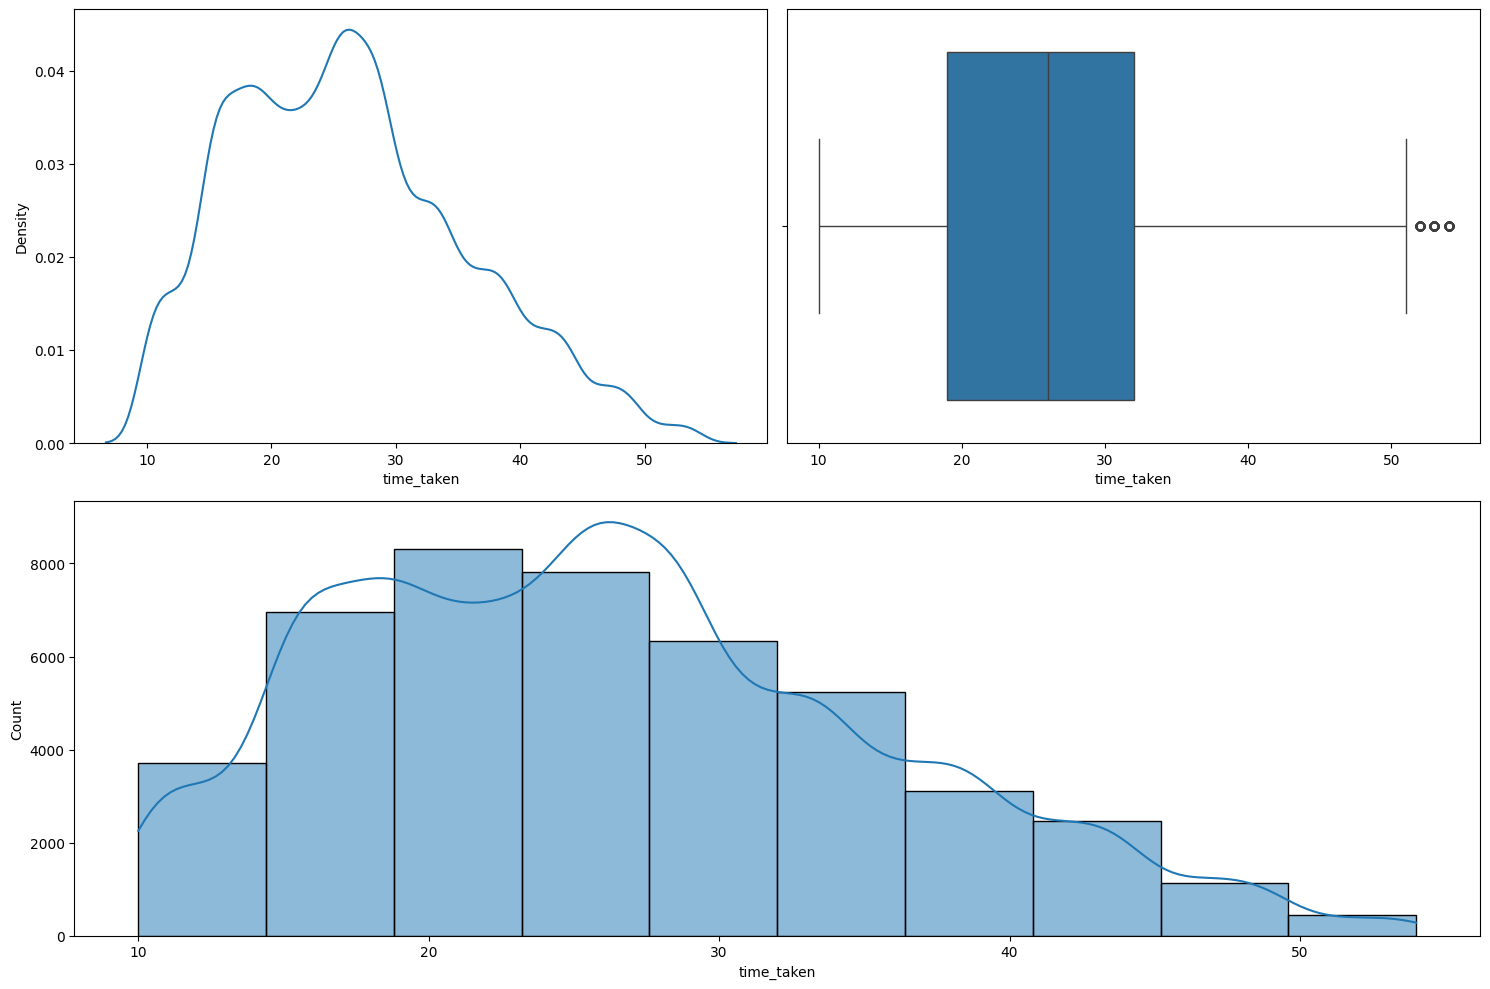

In [19]:
numerical_analysis(df_final, column_name='time_taken', bins = 10)

In [21]:
df_final['time_taken'].mean(), df_final['time_taken'].median()

(np.float64(26.297591314667486), np.float64(26.0))

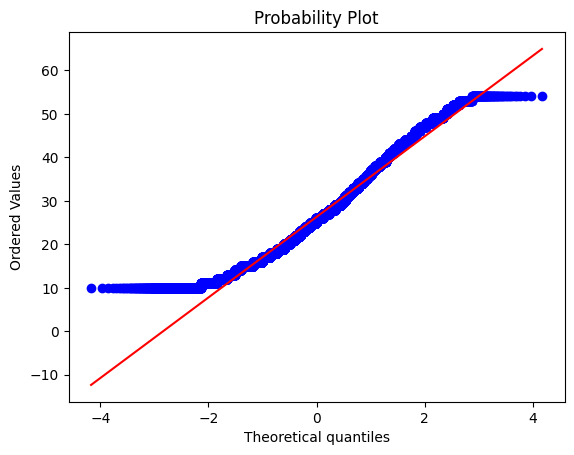

In [23]:
probplot(df_final['time_taken'], plot = plt)
plt.show()

In [24]:
test_for_normality(df_final,column_name='time_taken')

Jarque Bera Test for Normlality
0.0
Reject the null hypothesis. The data is not normally distributed.


In [26]:
df_final['traffic'].value_counts()

traffic
low       15477
jam       14143
medium    10947
high       4425
Name: count, dtype: int64

In [25]:
target_25 , target_75 = np.percentile(df_final['time_taken'], [25 , 75])

iqr = target_75 - target_25 

upper_bound = target_75 + (1.5*iqr)


df_final.loc[(df_final['time_taken']>upper_bound), "traffic"].value_counts()

traffic
jam     241
high     24
Name: count, dtype: int64

In [27]:
df_final.loc[(df_final['time_taken'] > upper_bound),"weather"].value_counts()

weather
fog           57
sunny         51
windy         44
cloudy        44
stormy        37
sandstorms    32
Name: count, dtype: int64

In [29]:
avg_distance = df_final.loc[: , "distance"].mean()

avg_distance_extreme = df_final.loc[(df_final['time_taken']>upper_bound), "distance"].mean()

print(avg_distance, avg_distance_extreme)

9.719296323199579 13.29215081388658


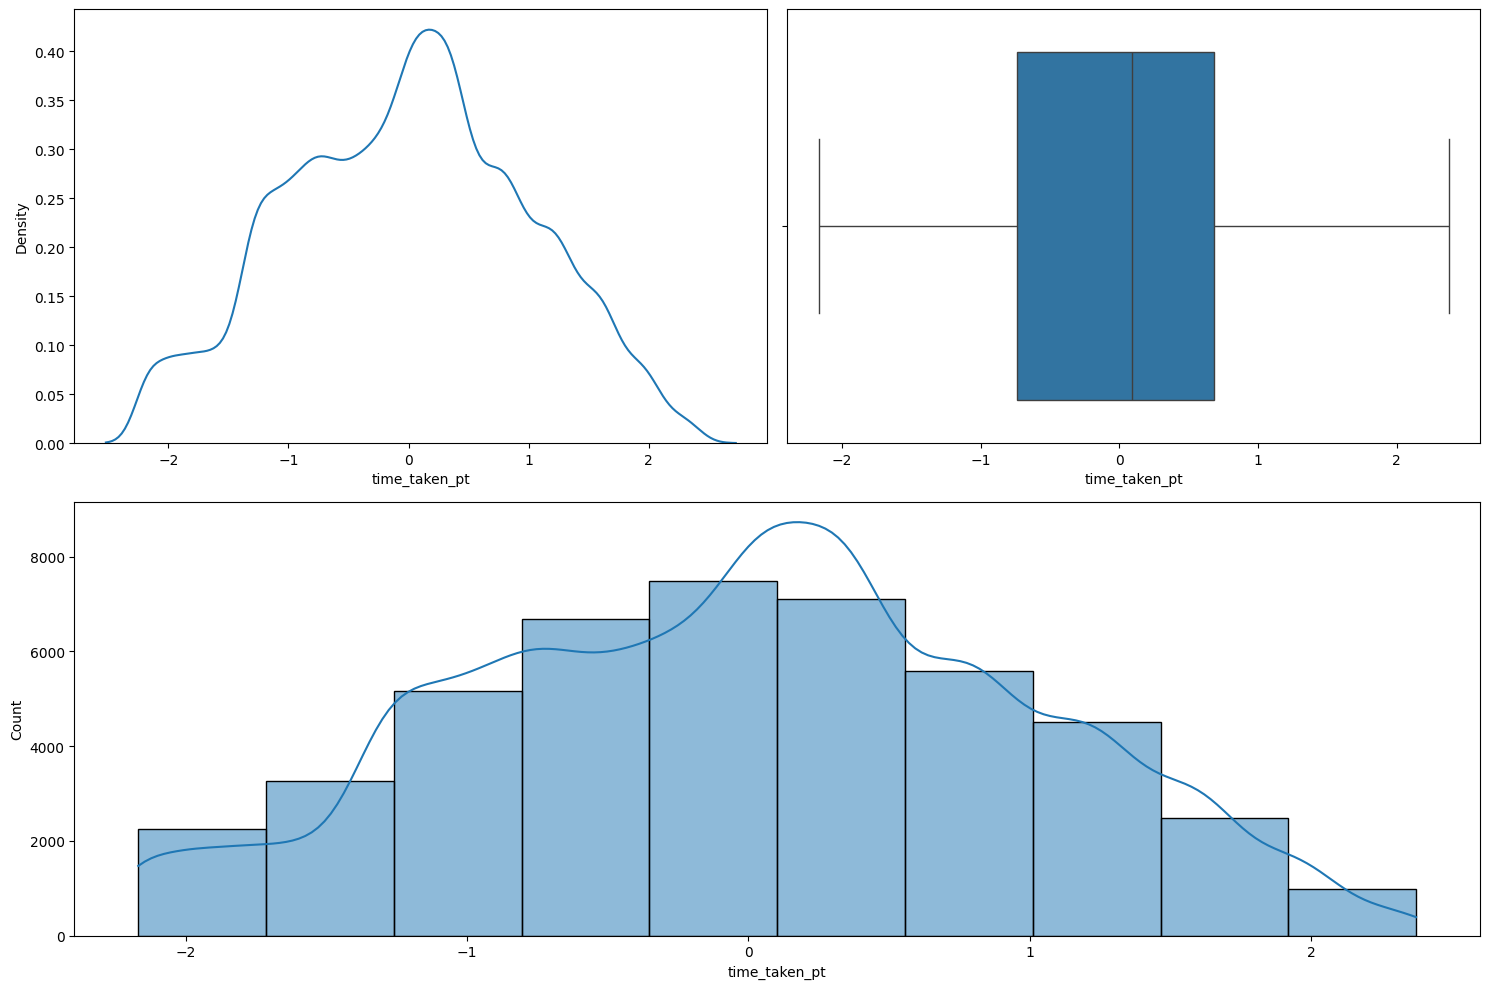

In [31]:
from sklearn.preprocessing import PowerTransformer


pt = PowerTransformer(method = 'yeo-johnson')

df_final['time_taken_pt'] = pt.fit_transform(df_final[['time_taken']])


numerical_analysis(df_final, 'time_taken_pt' , bins = 10)

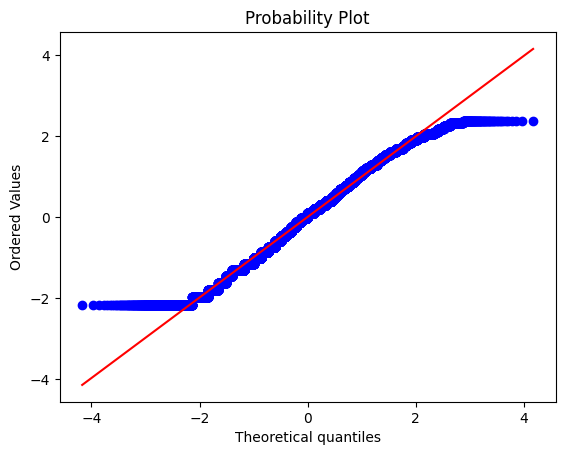

In [32]:
probplot(df_final['time_taken_pt'], plot=plt)
plt.show()

In [33]:
test_for_normality(df_final, 'time_taken_pt')

Jarque Bera Test for Normlality
3.0540463611616703e-145
Reject the null hypothesis. The data is not normally distributed.
